# Adversarial Robustness in Vision-Based Robot Navigation

## Part 2: Object Detection Models and Adversarial Attacks

This notebook:
1. Loads pre-trained object detection models (YOLOv8, MobileNet)
2. Implements FGSM and PGD attacks
3. Evaluates attack effectiveness on hazard detection

Using device: mps
Using device: mps
✅ Found 404 front camera images
Dataset ready with 400 images


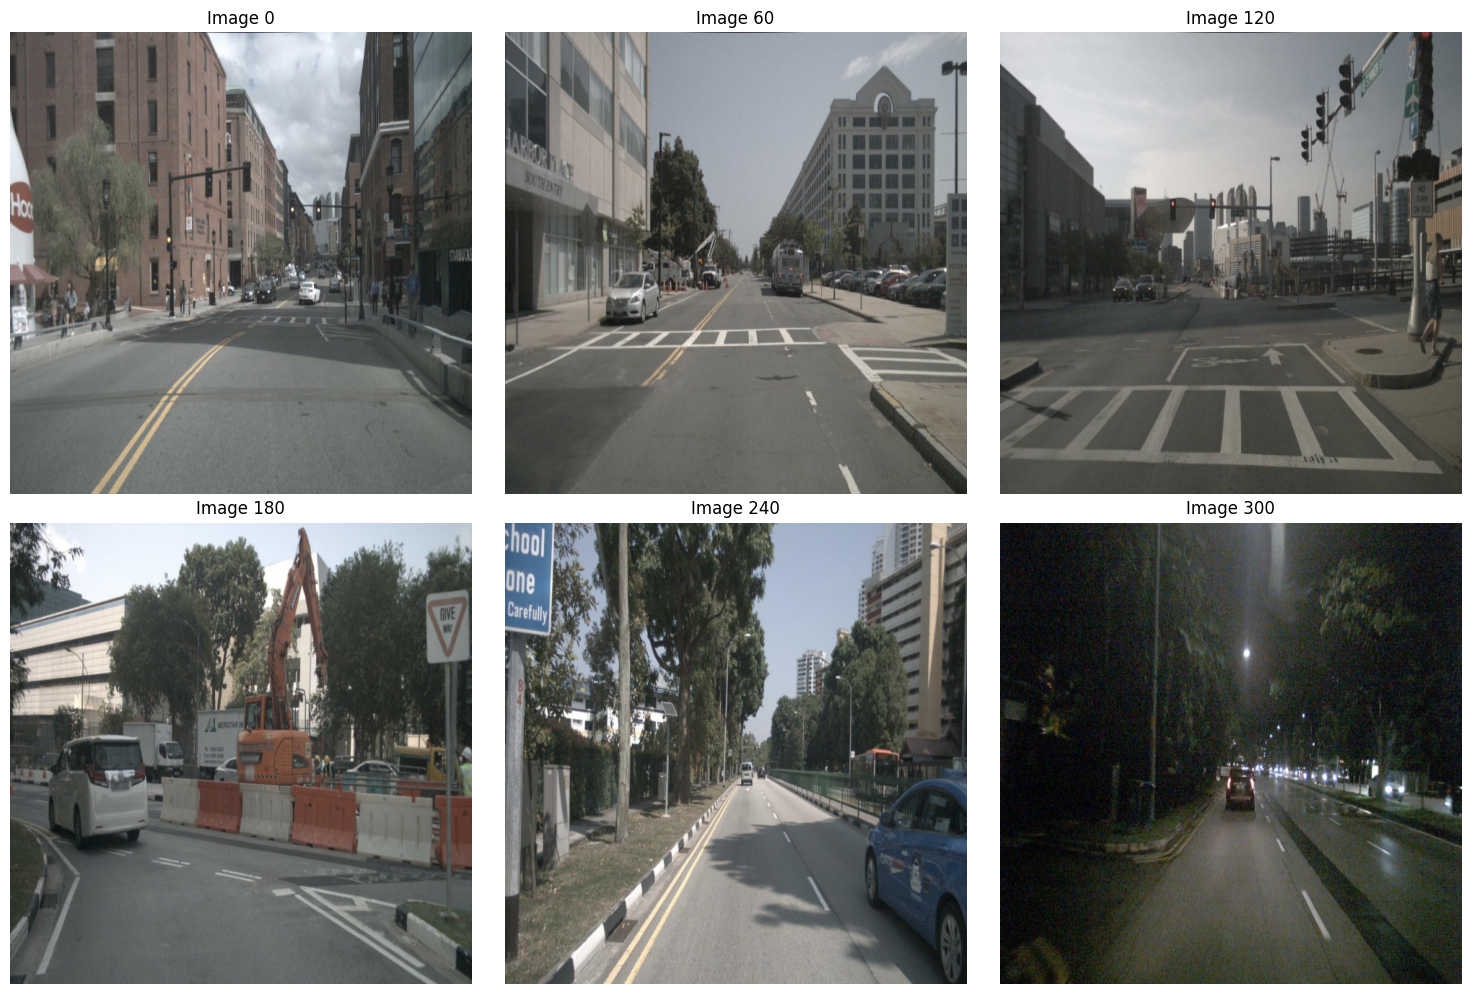

Dataset ready with 400 images
Dataset loaded with 400 images


In [1]:
# Essential imports
import os
import cv2
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from ultralytics import YOLO
import torchvision
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from tqdm import tqdm
import json
from collections import defaultdict
import time

# Set seeds
np.random.seed(42)
torch.manual_seed(42)

# Device setup
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

# Load dataset from previous notebook
from src.dataset_preparation import SimpleNavigationDataset
dataset = SimpleNavigationDataset(num_images=400)
print(f"Dataset loaded with {len(dataset)} images")

## Load Pre-trained Object Detection Models

In [2]:
# Load YOLOv8 model
print("Loading YOLOv8...")
yolo_model = YOLO('/Users/raju0103/Desktop/College Stuff/Northeastern/FAI/FAI_Final_Project/models/weights/yolov8n.pt')  # nano version for speed

# IMPORTANT: Set model to use CPU for now to avoid MPS issues
device = 'cpu'  # Force CPU usage for YOLO
print(f"Using device: {device}")

# Define critical classes for navigation (COCO dataset indices)
CRITICAL_CLASSES = {
    0: 'person',
    1: 'bicycle', 
    2: 'car',
    3: 'motorcycle',
    5: 'bus',
    7: 'truck'
}

print(f"Loaded YOLOv8 nano")
print(f"Critical classes for navigation: {list(CRITICAL_CLASSES.values())}")

Loading YOLOv8...
Using device: cpu
Loaded YOLOv8 nano
Critical classes for navigation: ['person', 'bicycle', 'car', 'motorcycle', 'bus', 'truck']



0: 640x640 4 persons, 4 cars, 1 traffic light, 1 umbrella, 169.2ms
Speed: 9.5ms preprocess, 169.2ms inference, 12.0ms postprocess per image at shape (1, 3, 640, 640)


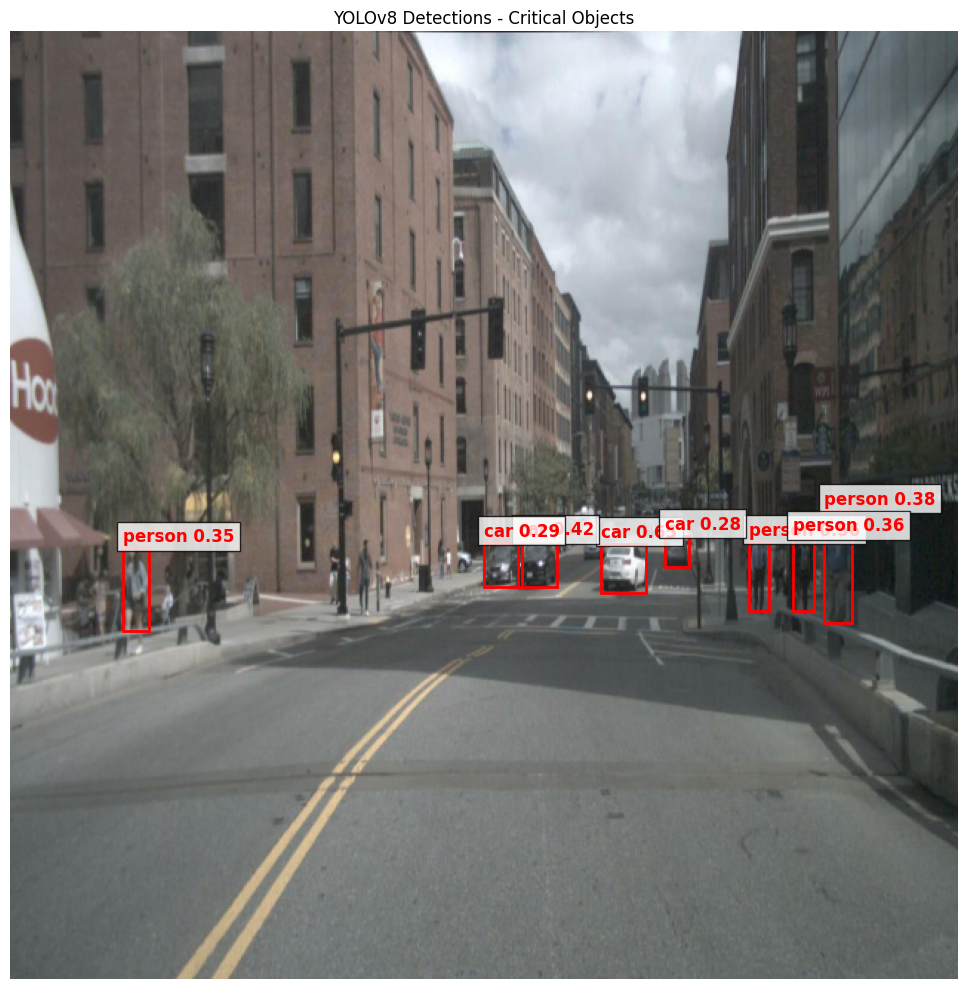

In [3]:
# Test detection on sample image
test_idx = 0
test_img, test_path = dataset.load_image(test_idx)

# Ensure float32 and correct format
test_img_input = (test_img * 255).astype(np.uint8)  # YOLO expects uint8 [0-255]

# Run YOLO detection
results = yolo_model(test_img_input)
detections = results[0].boxes

# Visualize detections
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.imshow(test_img)

if detections is not None:
    boxes = detections.xyxy.cpu().numpy()
    classes = detections.cls.cpu().numpy().astype(int)
    confidences = detections.conf.cpu().numpy()
    
    for box, cls, conf in zip(boxes, classes, confidences):
        if cls in CRITICAL_CLASSES:
            x1, y1, x2, y2 = box
            rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, 
                                   linewidth=2, edgecolor='red', facecolor='none')
            ax.add_patch(rect)
            ax.text(x1, y1-5, f"{CRITICAL_CLASSES[cls]} {conf:.2f}", 
                   color='red', fontsize=12, weight='bold',
                   bbox=dict(facecolor='white', alpha=0.8))

ax.set_title("YOLOv8 Detections - Critical Objects")
ax.axis('off')
plt.tight_layout()
plt.show()

## Implement Adversarial Attacks

In [4]:
class SimpleAdversarialAttacks:
    """Simple adversarial attacks using random perturbations"""
    
    def __init__(self, model):
        self.model = model
        self.critical_classes = CRITICAL_CLASSES
    
    def random_attack(self, image, epsilon=0.03):
        """Random noise attack"""
        noise = np.random.uniform(-epsilon, epsilon, image.shape)
        perturbed = np.clip(image + noise, 0, 1)
        return perturbed
    
    def targeted_attack(self, image, epsilon=0.03, num_tries=10):
        """
        Try multiple random perturbations and keep the one that reduces detections most
        """
        original = image.copy()
        
        # Get original detections
        orig_results = self.model((original * 255).astype(np.uint8))
        orig_count = 0
        if orig_results[0].boxes is not None:
            classes = orig_results[0].boxes.cls.cpu().numpy().astype(int)
            orig_count = sum(1 for cls in classes if cls in self.critical_classes)
        
        best_perturbed = original
        min_detections = orig_count
        
        # Try multiple random perturbations
        for _ in range(num_tries):
            noise = np.random.uniform(-epsilon, epsilon, original.shape)
            perturbed = np.clip(original + noise, 0, 1)
            
            # Test detection
            results = self.model((perturbed * 255).astype(np.uint8))
            count = 0
            if results[0].boxes is not None:
                classes = results[0].boxes.cls.cpu().numpy().astype(int)
                count = sum(1 for cls in classes if cls in self.critical_classes)
            
            # Keep if better
            if count < min_detections:
                min_detections = count
                best_perturbed = perturbed
        
        return best_perturbed

# Create attack instance
attacker = SimpleAdversarialAttacks(yolo_model)
print("Adversarial attack module ready")

Adversarial attack module ready


## Visualize Attack Effects

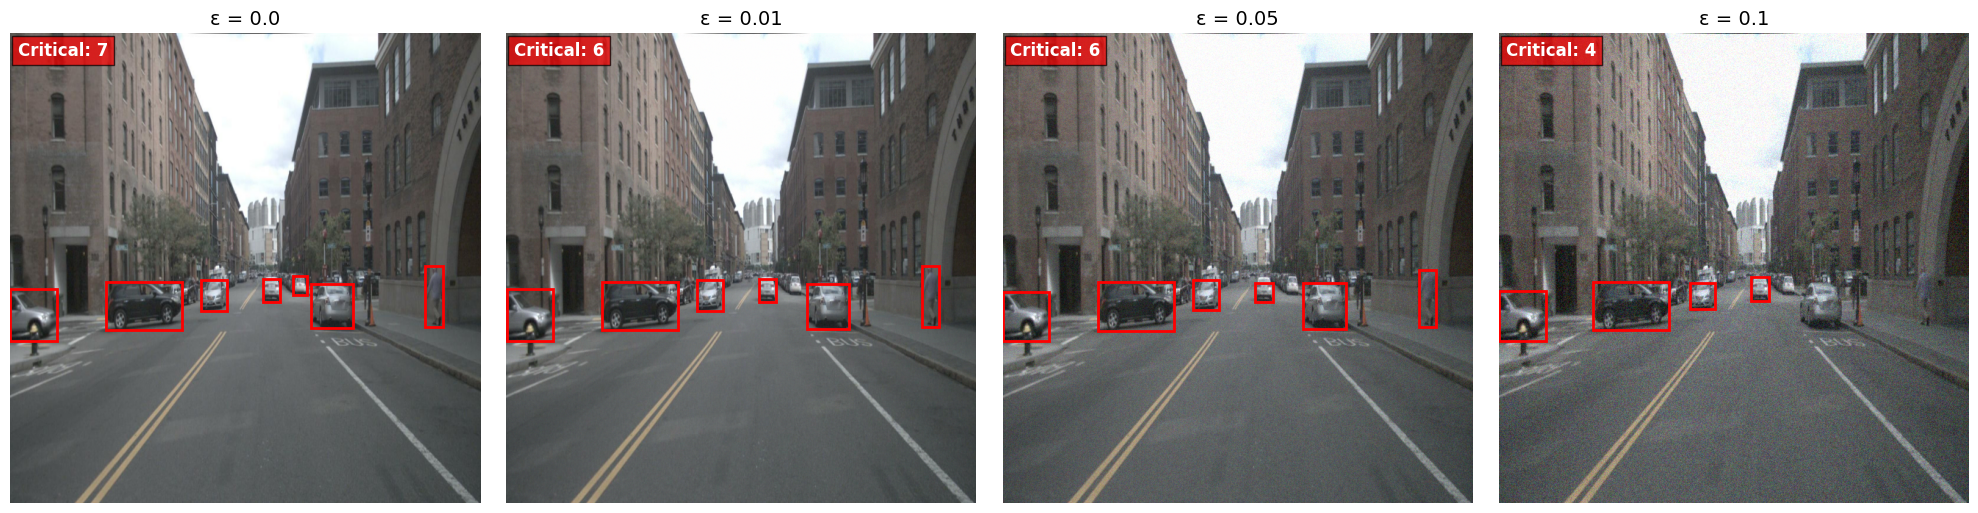

In [5]:
# Generate adversarial examples with different epsilon values
test_img, test_path = dataset.load_image(10)

# Different epsilon values
epsilons = [0.0, 0.01, 0.05, 0.1]
fig, axes = plt.subplots(1, 4, figsize=(20, 5))

for idx, eps in enumerate(epsilons):
    if eps == 0.0:
        adv_img = test_img
    else:
        adv_img = attacker.targeted_attack(test_img, epsilon=eps, num_tries=20)
    
    # Run detection
    results = yolo_model((adv_img * 255).astype(np.uint8), verbose=False)
    
    # Display
    axes[idx].imshow(adv_img)
    axes[idx].set_title(f'ε = {eps}', fontsize=14)
    
    # Count critical objects
    critical_count = 0
    if results[0].boxes is not None:
        boxes = results[0].boxes.xyxy.cpu().numpy()
        classes = results[0].boxes.cls.cpu().numpy().astype(int)
        
        for box, cls in zip(boxes, classes):
            if cls in CRITICAL_CLASSES:
                critical_count += 1
                x1, y1, x2, y2 = box
                rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, 
                                       linewidth=2, edgecolor='red', facecolor='none')
                axes[idx].add_patch(rect)
    
    axes[idx].text(10, 30, f'Critical: {critical_count}', 
                  color='white', fontsize=12, weight='bold',
                  bbox=dict(facecolor='red', alpha=0.7))
    axes[idx].axis('off')

plt.tight_layout()
plt.savefig('experiments/visualizations/attack_visualization.png', dpi=150, bbox_inches='tight')
plt.show()

## Evaluate Attack Effectiveness

In [6]:
def evaluate_attacks(dataset, attacker, num_samples=50):
    """Evaluate attack effectiveness"""
    epsilons = [0.01, 0.04, 0.07, 0.1]
    results = defaultdict(list)
    
    print(f"Evaluating attacks on {num_samples} images...")
    
    for img_idx in tqdm(range(num_samples)):
        img, _ = dataset.load_image(img_idx)
        
        # Original detection (suppress output)
        orig_results = yolo_model((img * 255).astype(np.uint8), verbose=False)
        orig_critical = 0
        if orig_results[0].boxes is not None:
            classes = orig_results[0].boxes.cls.cpu().numpy().astype(int)
            orig_critical = sum(1 for cls in classes if cls in CRITICAL_CLASSES)
        
        # Skip if no critical objects
        if orig_critical == 0:
            continue
            
        # Test each epsilon
        for eps in epsilons:
            # Attack
            adv_img = attacker.targeted_attack(img, epsilon=eps, num_tries=10)
            adv_results = yolo_model((adv_img * 255).astype(np.uint8), verbose=False)
            
            adv_critical = 0
            if adv_results[0].boxes is not None:
                classes = adv_results[0].boxes.cls.cpu().numpy().astype(int)
                adv_critical = sum(1 for cls in classes if cls in CRITICAL_CLASSES)
            
            results[eps].append({
                'original': orig_critical,
                'adversarial': adv_critical,
                'suppressed': orig_critical - adv_critical
            })
    
    return results

# Run evaluation
evaluation_results = evaluate_attacks(dataset, attacker, num_samples=50)

Evaluating attacks on 50 images...


100%|██████████| 50/50 [05:31<00:00,  6.63s/it]


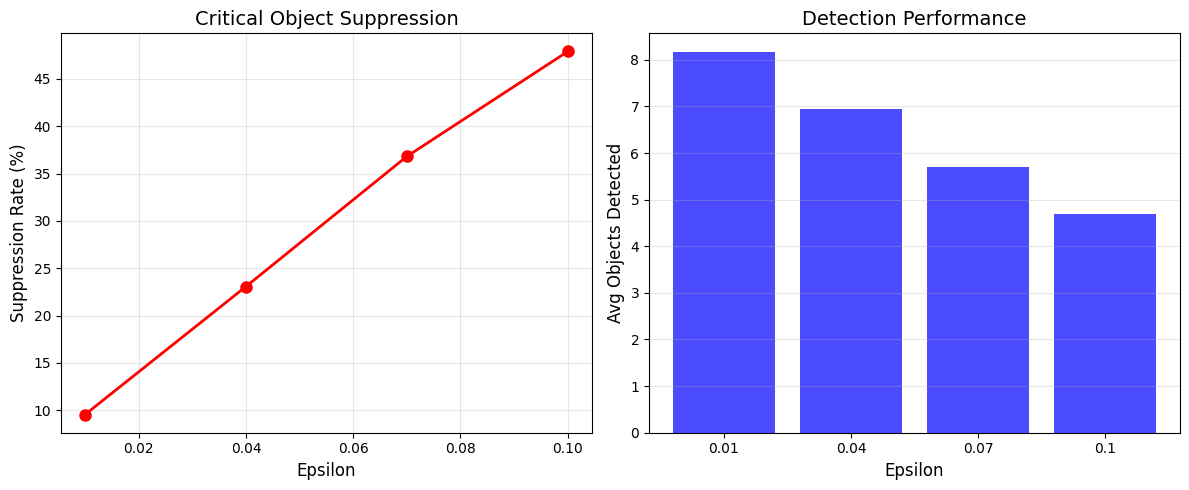

In [7]:
# Plot results
epsilons = sorted(evaluation_results.keys())
suppression_rates = []
avg_detected = []

for eps in epsilons:
    data = evaluation_results[eps]
    if data:
        total_orig = sum(d['original'] for d in data)
        total_supp = sum(d['suppressed'] for d in data)
        suppression_rates.append(total_supp / total_orig * 100)
        avg_detected.append(np.mean([d['adversarial'] for d in data]))
    else:
        suppression_rates.append(0)
        avg_detected.append(0)

# Create plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Suppression rate
ax1.plot(epsilons, suppression_rates, 'o-', linewidth=2, markersize=8, color='red')
ax1.set_xlabel('Epsilon', fontsize=12)
ax1.set_ylabel('Suppression Rate (%)', fontsize=12)
ax1.set_title('Critical Object Suppression', fontsize=14)
ax1.grid(True, alpha=0.3)

# Average detections
ax2.bar(range(len(epsilons)), avg_detected, color='blue', alpha=0.7)
ax2.set_xlabel('Epsilon', fontsize=12)
ax2.set_ylabel('Avg Objects Detected', fontsize=12)
ax2.set_title('Detection Performance', fontsize=14)
ax2.set_xticks(range(len(epsilons)))
ax2.set_xticklabels(epsilons)
ax2.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('experiments/visualizations/attack_effectiveness.png', dpi=150)
plt.show()

## Summary Statistics

In [8]:
# Print summary
print("ATTACK EFFECTIVENESS SUMMARY")
print("=" * 50)

for eps in sorted(evaluation_results.keys()):
    data = evaluation_results[eps]
    if data:
        total_original = sum(d['original'] for d in data)
        total_adversarial = sum(d['adversarial'] for d in data)
        total_suppressed = sum(d['suppressed'] for d in data)
        suppression_rate = (total_suppressed / total_original) * 100
        
        print(f"\nε = {eps}:")
        print(f"  Images evaluated: {len(data)}")
        print(f"  Total objects (original): {total_original}")
        print(f"  Total objects (adversarial): {total_adversarial}")
        print(f"  Objects suppressed: {total_suppressed}")
        print(f"  Suppression rate: {suppression_rate:.1f}%")

# Save results
with open('experiments/results/attack_results.json', 'w') as f:
    json.dump({str(k): v for k, v in evaluation_results.items()}, f, indent=2)

print("\nResults saved to experiments/results/attack_results.json")

ATTACK EFFECTIVENESS SUMMARY

ε = 0.01:
  Images evaluated: 50
  Total objects (original): 451
  Total objects (adversarial): 408
  Objects suppressed: 43
  Suppression rate: 9.5%

ε = 0.04:
  Images evaluated: 50
  Total objects (original): 451
  Total objects (adversarial): 347
  Objects suppressed: 104
  Suppression rate: 23.1%

ε = 0.07:
  Images evaluated: 50
  Total objects (original): 451
  Total objects (adversarial): 285
  Objects suppressed: 166
  Suppression rate: 36.8%

ε = 0.1:
  Images evaluated: 50
  Total objects (original): 451
  Total objects (adversarial): 235
  Objects suppressed: 216
  Suppression rate: 47.9%

Results saved to experiments/results/attack_results.json
